## Returning to Implementation of a basic CNN

<img src="https://snag.gy/yjkZ0C.jpg" >

# Minibatch Training

In [1]:
from fastai_lib import get_data, test_near
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'gray'

In [2]:
# loading the dataset
x_train, y_train, x_valid, y_valid = get_data()

# getting some basic params
n, m = x_train.shape
n_classes = y_train.max() + 1
n_hidden = 50

# our simple model from before

class Model(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.layers = [
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        ]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [3]:
model = Model(m, n_hidden, 10)
pred = model(x_train)

## Review of Cross Entropy Loss

This is based on softmax

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [4]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'label': ['cat', 'dog', 'plane', 'fish', 'building'], 'output': np.random.rand(5)})
df['exp']= np.log(df['output'])
df['softmapx'] = df['exp'] / df['exp'].sum()
df

,label,output,exp,softmapx
0,cat,0.882275,-0.125251,0.031979
1,dog,0.502540,-0.688080,0.175678
2,plane,0.244549,-1.408342,0.359574
3,fish,0.672065,-0.397400,0.101463
4,building,0.273180,-1.297626,0.331306


In [5]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

<img src='https://snag.gy/jQnH5O.jpg' style="width:400px" >

In [6]:
sm_pred = log_softmax(pred)

In [7]:
# consider the first 3 elements of the truth
print(y_train[:3])

# compare to our predictions
# first 3
row_idx = [0, 1, 2]

# what was the probabilty for each class?
col_idx = [5, 0 ,4]

# whats the probability associated with 5, 0 and 4 
# an example of advanced indexing
sm_pred[row_idx, col_idx]

tensor([5, 0, 4])


tensor([-2.3949, -2.2743, -2.3425], grad_fn=<IndexBackward>)

In [8]:
def nll(inputs, target):
    """ negative log-likelihood """ 
    return -inputs[range(target.shape[0]), target].mean()

In [9]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3053, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [10]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [11]:
test_near(nll(log_softmax(pred), y_train), loss)

### A trick for stability sake 

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [12]:
def logsumexp(x):
    # find max
    m = x.max(-1)[0]
    
    # and subtract and do summation of logs
    return m + (x-m[:,None]).exp().sum(-1).log()

In [13]:
test_near(logsumexp(pred), pred.logsumexp(-1))

so now we can replace and update our `log_softmax` function

In [14]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

test_near(nll(log_softmax(pred), y_train), loss)

In [15]:
# The pytorch version
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [16]:
# the above function is combined into cross entropy
test_near(F.cross_entropy(pred, y_train), loss)

# Basic Training Loop

In [17]:
loss_func = F.cross_entropy

In [18]:
def accuracy(out, y_true):
    """
    torch.argmax(out, dim=1) == yb <-- returns bools
    .float() <-- changes to float
    .mean() <-- gives average accuracy
    """
    return (torch.argmax(out, dim=1) == y_true).float().mean()

In [19]:
bs = 64 # batchsize
lr = 0.5 # learning rate
epochs = 1 # how many epoches to train for

n_batches = (n-1) // bs + 1

xb = x_train[0:bs]
yb = y_train[0:bs]
preds = model(xb)

# look at the predictions (reminder tha the model has not been trained yet)
preds[0], preds.shape

(tensor([ 0.0158,  0.0640, -0.0864, -0.1477,  0.0200, -0.0735,  0.1565,  0.1732,
          0.0614, -0.0440], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [20]:
loss_func(preds, yb)

tensor(2.3138, grad_fn=<NllLossBackward>)

In [21]:
accuracy(preds, yb)

tensor(0.0469)

## Train Loop!

In [22]:
for epoch in range(epochs):
    for i in range(n_batches):
        
        # get indices of batch
        start_i = i*bs
        end_i = start_i + bs
        
        # pull our batch out
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        
        # calculate our loss
        loss = loss_func(model(xb), yb)
        
        # backpropogation
        loss.backward()
        
        with torch.no_grad():
            
            # go through all layers
            for layer in model.layers:
                
                # if weights are found, update the weights
                # and update the bias
                if hasattr(layer, 'weight'):
                    layer.weight -= layer.weight.grad * lr
                    layer.bias -= layer.bias.grad * lr
                    
                    # zero out the parameters for the next
                    # iteration
                    layer.weight.grad.zero_()
                    layer.bias.grad.zero_()
            

In [23]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1419, grad_fn=<NllLossBackward>), tensor(0.9375))

## Simplify the training loop

### Parameters

Use nn.Module.__setattr__ and move relu to functional. 

So instead of looping through LAYERS, we will be looping through the parameters. Note the `DummyModule` below. Using the `parameters` class method, if we can collect all the layer-related attributes in this class as modules, we can easily loop through all the parameters.

#### How is modules self-populated?

There's a special `__setattr__` will automatically be called anytime the `self.some_attr` is being called. In the section below, everytime a new layer is set, referenace is added to the dictionary

In [24]:
class DummyModule():
    def __init__(self, n_in, n_hidden, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_out)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self):
        return f'{self._modules}'
        
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [25]:
mdl = DummyModule(m, n_hidden, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

#### Example of looping through the parameters

Even though we didnt create the layers in list or dictionary, they are still called and displayed using the `self.parameters`

In [26]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Pytorch has a similar setattr method

Will use `nn.Module.__setattr__` 

In [27]:
class Model(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_out)
        
    def __call__(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

#### Note that we can see all the layers as follows

Not that we can easily pull out any of the name nn.layer objects using the `named_children` method which behaves a lot like the `parameters`method that we set above

In [28]:
model = Model(m, n_hidden, 10)
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


#### Also note that pytorch has a similar __repr__ already implemented

In [29]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [30]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [33]:
def fit():
    for epoch in range(epochs):
        for i in range(n_batches):

            # get indices of batch
            start_i = i*bs
            end_i = start_i + bs

            # pull our batch out
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]

            # calculate our loss
            loss = loss_func(model(xb), yb)

            # backpropogation
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()
            

In [34]:
fit()
loss_func(model)

TypeError: cross_entropy() missing 1 required positional argument: 'target'

## Making the layers a list instead of individual attributes

In [35]:
# given a list of layers
n_hidden = 50
layers = [nn.Linear(m, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10)]

In [36]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        
        # this by itself will not make them parameters
        self.layers = layers
        
        # need to go through them and call 
        # add module, and will register all the layers
        for idx, layer in enumerate(self.layers):
            self.add_module(f'layer_{idx}', layer)
                            
    def __call__(self, x):
        for layer in self.layers:
            x =layer(x)
        return x
                            

In [37]:
model = Model(layers)

In [38]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## Pytorch Module List

This simplifies it even more, removing the loop registration, and using `ModuleList`

In [39]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        
        # this by itself will not make them parameters
        self.layers = nn.ModuleList(layers)
                            
    def __call__(self, x):
        for layer in self.layers:
            x =layer(x)
        return x
                            

In [40]:
model = SequentialModel(layers)

In [41]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

## And even simplier still, nn.Sequential

`nn.Sequential` will take care of that. If you look at the source code of Sequential, its almost exactly the same

In [42]:
model = nn.Sequential(nn.Linear(m, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))

In [43]:
nn.Sequential??

Init signature: nn.Sequential(*args)
Source:        
class Sequential(Module):
    r"""A sequential container.
    Modules will be added to it in the order they are passed in the constructor.
    Alternatively, an ordered dict of modules can also be passed in.

    To make it easier to understand, here is a small example::

        # Example of using Sequential
        model = nn.Sequential(
                  nn.Conv2d(1,20,5),
                  nn.ReLU(),
                  nn.Conv2d(20,64,5),
                  nn.ReLU()
                )

        # Example of using Sequential with OrderedDict
        model = nn.Sequential(OrderedDict([
                  ('conv1', nn.Conv2d(1,20,5)),
                  ('relu1', nn.ReLU()),
                  ('conv2', nn.Conv2d(20,64,5)),
                  ('relu2', nn.ReLU())
                ]))
    """

    def __init__(self, *args):
        super(Sequential, self).__init__()
        if len(args) == 1 and isinstance(args[0], OrderedDict):
            

 ### Let's return to our fit function
 
 Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

Let's try and make the optimizer from scratch

In [44]:
class Optimizer():
    def __init__(self,params, lr=0.5):
        self.lr = lr
        self.params = list(params)
        
    def step(self):
        """
        This method replaces  the 
         for p in model.parameters(): p -= p.grad * lr
        """
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr
                
    def zero_grad(self):
        """
        This method implements
        model.zero_grad()
        
        model might be too general, and too drastic
        """
        for p in self.params:
            p.grad.data.zero_()

In [45]:
model = nn.Sequential(
    nn.Linear(m, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 10)
)

opt = Optimizer(model.parameters())

### let's sub in our optimizer

In [46]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [47]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.2493, grad_fn=<NllLossBackward>), tensor(0.9375))

### Luckily Pytorch takes care of this with `optim`

In [48]:
#export
from torch import optim

def get_model():
    model = nn.Sequential(nn.Linear(m,n_hidden), nn.ReLU(), nn.Linear(n_hidden,10))
    return model, optim.SGD(model.parameters(), lr=lr)

model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3602, grad_fn=<NllLossBackward>)

In [49]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [50]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1134, grad_fn=<NllLossBackward>), tensor(0.9375))

In [51]:
assert acc > 0.7

### Making Datasets and DataLoaders

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [58]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [59]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [60]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [61]:
model,opt = get_model()

In [62]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        
        # we have replace some of the other code
        # with our dataset class
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [63]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2123, grad_fn=<NllLossBackward>), tensor(0.9375))

## Making a Dataloader

The dataloader will manage things like:

- batch loading
- shuffling
- indexes

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

`yield` is a great command to get familiar with, it will execute lazily and will only provide a value at a time, without loading the whole list into memory

In [69]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds = ds
        self.bs = bs
        
    def __iter__(self):
        # to replace this with itertools
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

In [70]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [72]:
xb,yb = next(iter(valid_dl))

# check that these things are the right size
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

## Let's take a look at a sample

tensor(3)

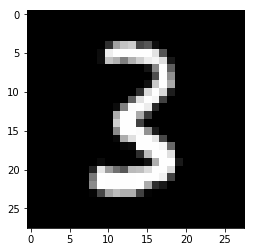

In [74]:
import matplotlib.pyplot as plt
plt.imshow(xb[0].view(28,28))
yb[0]

In [75]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [76]:
fit()

In [77]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0570, grad_fn=<NllLossBackward>), tensor(0.9844))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [84]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
        
    def __iter__(self):
        if self.shuffle:
            # if we are shuffling, we pull some random indexes
            self.idxs = torch.randperm(self.n)
        else:
            # otherwise pull teh indexes in order
            self.idxs = torch.arange(self.n)
            
        for i in range(0, self.n, self.bs): 
            yield self.idxs[i:i+self.bs]

In [85]:
small_ds = Dataset(*train_ds[:10])

In [86]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [87]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([1, 5, 0]), tensor([2, 3, 9]), tensor([8, 4, 7]), tensor([6])]

In [90]:
def collate(b):
    """
    Will grabs the Xs and Ys and stacks them up
    """
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds = ds
        self.sampler = sampler
        self.collate_fn = collate_fn
        
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

Now we create two samplers, one randomized, the other not

In [91]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [92]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

Let's confirm that the dataloaders are shuffling the way we expect them to

tensor(3)

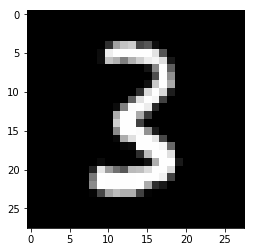

In [93]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

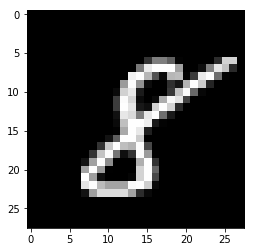

In [94]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(0)

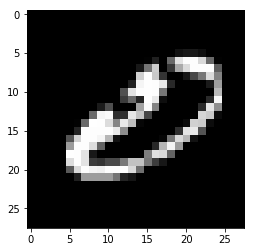

In [95]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [96]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2036, grad_fn=<NllLossBackward>), tensor(0.9531))

### PyTorch DataLoader

Let's take a look at the pre-built stuff, and we will see that the code does a very similar thing to what we have made

In [97]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [98]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [99]:
xb,yb = next(iter(train_dl))

In [100]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0851, grad_fn=<NllLossBackward>), tensor(0.9844))

In [101]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [102]:
xb,yb = next(iter(train_dl))

In [104]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3761, grad_fn=<NllLossBackward>), tensor(0.9375))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [105]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [106]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [108]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1736) tensor(0.9481)
1 tensor(0.1452) tensor(0.9576)
2 tensor(0.1400) tensor(0.9571)
3 tensor(0.1026) tensor(0.9688)
4 tensor(0.1564) tensor(0.9538)


In [109]:
assert acc>0.9